# German Traffic Sign Classification

---

In [1]:
import pandas as pd

df_total = pd.DataFrame()
for i in range(0,43):
    csv_file = '..\..\datasets\GTSRB_data\Final_Training\Images\%05d\GT-%05d.csv' % (i, i)
    the_path = '..\..\datasets\GTSRB_data\Final_Training\Images\%05d\\' % (i) 
    df=pd.read_csv(csv_file)
    df['Filename'] = the_path + df['Filename'] # prepend path to filename
    df_total = df_total.append(df) # append all dataframes to df_total
    
df_total.info() # display some information
#df_total['Filename'].head() # look at a few rows

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39209 entries, 0 to 239
Data columns (total 9 columns):
Filename    39209 non-null object
Width       39209 non-null int64
Height      39209 non-null int64
Roi.X1      39209 non-null int64
Roi.Y1      39209 non-null int64
Roi.X2      39209 non-null int64
Roi.Y2      39209 non-null int64
ClassId     39209 non-null int64
Damage      39209 non-null int64
dtypes: int64(8), object(1)
memory usage: 3.0+ MB


In [2]:
df_total = df_total.astype({"Damage": str}) # convert damage column to string
#df_total.info()

In [3]:
# create trn, val, tst split
import math
from sklearn.utils import shuffle
df_total_shuffled = shuffle(df_total, random_state=42)

trn_percentage = 0.8 # use 80 for training
val_percentage = 0.9 # use samples 0.8 to 0.9 for validation, rest for testing

trn_split = math.floor(len(df_total_shuffled)*trn_percentage)
val_split = math.floor(len(df_total_shuffled)*val_percentage)

df_trn = df_total_shuffled.iloc[0:trn_split]
df_val = df_total_shuffled.iloc[trn_split:val_split]
df_tst = df_total_shuffled.iloc[val_split:]

# check if sizes are correct
print(len(df_trn))
print(len(df_val))
print(len(df_tst))
print(len(df_trn) + len(df_val) + len(df_tst))
print(len(df_total_shuffled))

df_trn.groupby('Damage').count()
#df_val.groupby('Damage').count()
#df_tst.groupby('Damage').count()

31367
3921
3921
39209
39209


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
Damage,,,,,,,,
0,28385,28385,28385,28385,28385,28385,28385,28385
1,2982,2982,2982,2982,2982,2982,2982,2982


In [4]:
from keras_preprocessing.image import ImageDataGenerator

im_w = 64
im_h = 64
im_c = 1
bs = 128

datagen_temp = ImageDataGenerator()
gen_temp=datagen_temp.flow_from_dataframe(dataframe=df_trn, directory=".", x_col="Filename", y_col="Damage", class_mode="categorical", target_size=(im_w,im_h), batch_size=bs, color_mode='grayscale')

step_size_tmp = gen_temp.n//bs
import numpy as np
X_temp = np.empty((0,im_w,im_h,im_c))
for i in range(0, len(gen_temp)):
    (X,y) = gen_temp[i]
    X_temp = np.concatenate((X_temp,X), axis=0)
X_temp.shape

Found 31367 images belonging to 2 classes.


(31367, 64, 64, 1)

In [5]:
step_size_tmp*128

31360

In [6]:
flow_args = dict(directory=".", 
    x_col="Filename", 
    y_col="Damage", 
    class_mode="categorical", 
    target_size=(im_w,im_h), 
    batch_size=bs, 
    color_mode='grayscale')

generator_args = dict(featurewise_center=True, featurewise_std_normalization=True)

# build the generators
datagen_trn=ImageDataGenerator(**generator_args)
datagen_trn.fit(X_temp)
gen_trn=datagen_trn.flow_from_dataframe(dataframe=df_trn, **flow_args)

datagen_val=ImageDataGenerator(**generator_args)
datagen_val.fit(X_temp)
gen_val=datagen_val.flow_from_dataframe(dataframe=df_val, **flow_args)

datagen_tst=ImageDataGenerator(**generator_args)
datagen_tst.fit(X_temp)
gen_tst=datagen_tst.flow_from_dataframe(dataframe=df_tst, **flow_args)

Found 31367 images belonging to 2 classes.
Found 3921 images belonging to 2 classes.
Found 3921 images belonging to 2 classes.


In [8]:
# take a look at images from our generator
X_temp = np.empty((0,im_w,im_h,im_c))
for i in range(0, len(gen_trn)):
    (X,y) = gen_trn[i]
    X_temp = np.concatenate((X_temp,X), axis=0)
X_temp.shape


(31367, 64, 64, 1)

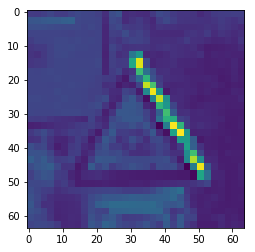

In [9]:
import matplotlib.pyplot as plt

plt.imshow(X_temp[50,:,:,0])
plt.show()


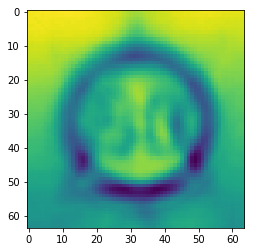

In [10]:
# its a bit worrying that this image is not completely all ones...
plt.imshow(np.std(X_temp[:,:,:,0],axis=0))
plt.show()

**Model architecture**

I use the same architecture as the guys used for classifying sign identity for the german dataset, shown below

![Model](model_architecture.png)



In [38]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

# build a simple model
model = Sequential()

input_shape = (im_w, im_h, im_c)
num_classes = 2

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
__________

In [39]:
# compile model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [40]:
import numpy as np
import sklearn.metrics

def comp_stats(gen):
    
    y_total = np.empty((0,2))
    for i in range(0, len(gen)):
        (X,y) = gen[i]
        y_total = np.concatenate((y_total,y), axis=0)
    return np.sum(y_total, axis=0)

def comp_metrics(gen, model):
    y_total = np.empty((0,2))
    y_total_pred = np.empty((0,2))
    for i in range(0, len(gen)):
        (X,y) = gen[i]
        y_total = np.concatenate((y_total,y), axis=0)
        y_pred = model.predict(X)
        y_total_pred = np.concatenate((y_total_pred, y_pred), axis=0)
    acc = sklearn.metrics.accuracy_score(y_total, y_total_pred > 0.5)
    
    class_freq = np.sum(y_total,axis=0)
    accuracy_chance = (class_freq[0]+class_freq[1]-class_freq[1])/(class_freq[1]+class_freq[0])
    
    auc = sklearn.metrics.roc_auc_score(y_total, y_total_pred)
    
    apr = sklearn.metrics.average_precision_score(y_total, y_total_pred)
    
    return (acc, accuracy_chance, auc, apr)
    

In [41]:
from keras.callbacks import Callback

class roc_callback(Callback):
    def __init__(self,gen_trn,gen_val,use_trn):
        self.gen_trn = gen_trn
        self.gen_val = gen_val
        self.auc_trn = []
        self.auc_val = []
        self.acc_trn = []
        self.acc_val = []
        self.apr_trn = []
        self.apr_val = []

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        
        (acc_val_tmp, acc_chance, auc_val_tmp, apr_val_tmp) = comp_metrics(self.gen_val, self.model)
        
        self.acc_val.append(acc_val_tmp)
        self.auc_val.append(auc_val_tmp)
        self.apr_val.append(apr_val_tmp)
        
        if (use_trn):
            (acc_trn_tmp, acc_chance, auc_trn_tmp, apr_trn_tmp) = comp_metrics(self.gen_trn, self.model)

            self.acc_trn.append(acc_trn_tmp)
            self.auc_trn.append(auc_trn_tmp)
            self.apr_trn.append(apr_trn_tmp)

            print('\rtrn-auc: %s - val-auc: %s' % (str(round(auc_trn_tmp,4)),str(round(auc_val_tmp,4))),end=100*' '+'\n')
        else:
            print('\rval-acc: %s - val-auc: %s' % (str(round(acc_val_tmp,4)),str(round(auc_val_tmp,4))),end=100*' '+'\n')
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [42]:
# train the model

my_auc_callback = roc_callback(gen_trn,gen_val,use_trn=False) # if we set use_trn to false, the computation time is much faster
#my_auc_callback.model = model
#my_auc_callback.on_epoch_end(epoch=[])

In [43]:
history = model.fit_generator(gen_trn, # input data
    steps_per_epoch=len(gen_trn),
    epochs=50,      
    verbose=2,
    class_weight={0:1, 1:8},
    use_multiprocessing=False,
    callbacks=[my_auc_callback])    

print('Training complete!')

Epoch 1/50
 - 23s - loss: 1.0807 - acc: 0.6794
val-acc: 0.6274 - val-auc: 0.7485                                                                                                    
Epoch 2/50
 - 23s - loss: 0.9073 - acc: 0.7686
val-acc: 0.7766 - val-auc: 0.8604                                                                                                    
Epoch 3/50
 - 23s - loss: 0.7185 - acc: 0.8247
val-acc: 0.8426 - val-auc: 0.91                                                                                                    
Epoch 4/50
 - 22s - loss: 0.6465 - acc: 0.8438
val-acc: 0.9072 - val-auc: 0.9473                                                                                                    
Epoch 5/50
 - 23s - loss: 0.4882 - acc: 0.8819
val-acc: 0.9332 - val-auc: 0.9607                                                                                                    
Epoch 6/50
 - 23s - loss: 0.3933 - acc: 0.9061
val-acc: 0.9128 - val-auc: 0.9679                 

val-acc: 0.9829 - val-auc: 0.9901                                                                                                    
Epoch 47/50
 - 22s - loss: 0.0547 - acc: 0.9892
val-acc: 0.9821 - val-auc: 0.9883                                                                                                    
Epoch 48/50
 - 22s - loss: 0.0592 - acc: 0.9889
val-acc: 0.985 - val-auc: 0.9874                                                                                                    
Epoch 49/50
 - 23s - loss: 0.0638 - acc: 0.9875
val-acc: 0.9819 - val-auc: 0.991                                                                                                    
Epoch 50/50
 - 22s - loss: 0.0884 - acc: 0.9838
val-acc: 0.9855 - val-auc: 0.9941                                                                                                    
Training complete!


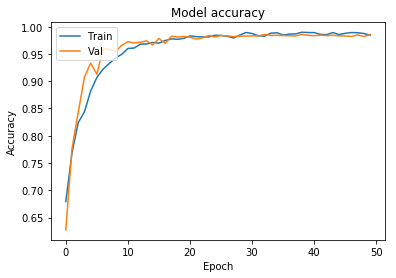

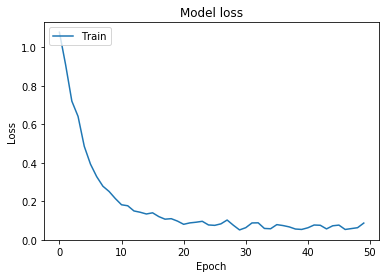

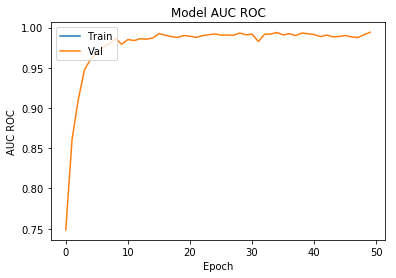

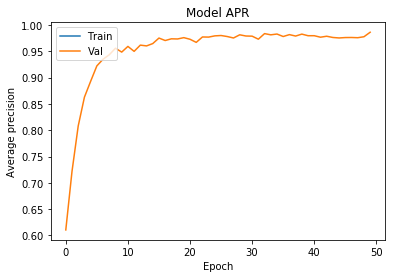

In [44]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(my_auc_callback.acc_val)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation AUC values
plt.plot(my_auc_callback.auc_trn)
plt.plot(my_auc_callback.auc_val)
plt.title('Model AUC ROC')
plt.ylabel('AUC ROC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation APR values
plt.plot(my_auc_callback.apr_trn)
plt.plot(my_auc_callback.apr_val)
plt.title('Model APR')
plt.ylabel('Average precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [45]:
print(comp_metrics(gen_tst, model))
print(comp_stats(gen_tst))

(0.9846977811782709, 0.9000255036980362, 0.9929922840487853, 0.9835696069977411)
[3529.  392.]


In [46]:
model.save('trained_german.h5')